## Objective - Rank universities based on different features

#### Import modules and prepare dataset.

In [42]:
# Import sklearn tools
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from scipy.special import expit

# Load dataset
dataset = pd.read_csv('shanghai_data.csv')

# Check which columns have null values.
for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print(f"% of missing data in '{col}' - {pct_missing*100:.2f}%")

# Fill the data.
dataset.fillna(dataset.mean(), inplace=True)

# Checking for duplicates. NOTE: world_rank will become the target.
print('Duplication in dataset: {}'.format(dataset.duplicated(subset=['world_rank']).any()))    # -> True

# NOTE: There are duplicates in the dataset because the rankings change every year, so the rankings are updated.

# Split data into target and data variables.]
data = dataset.loc[:, 'total_score':'pcp'].to_numpy()

# Encoding target colum (target is not continuous).
target = dataset.loc[:, 'world_rank'].to_numpy()

print('data.shape: {}'.format(data.shape))
print('target.shape: {}'.format(target.shape))

# University names (for reference).
university_names = dataset.loc[:, 'university_name'].to_numpy()

print(f'target.dtype: {target.dtype}')    # -> object

# NOTE: The reason why the above code returns object is bc the data is string,
#       but the strings must be the same length, so it is stored in this dtype.

# Get indexes where the targets can be converted to floats.
indexes = []

for index in range(len(target)):
    if '-' not in target[index]:
        indexes.append(index)

print('target (after sample selection): {}'.format(target := target[indexes].astype(float)))

print('target.shape (after sample selection): {}'.format(target.shape))
print('data.shape (after sample selection): {}'.format((data := data[indexes]).shape))

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(data, target)

# Scale the data.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

% of missing data in 'world_rank' - 0.00%
% of missing data in 'university_name' - 0.02%
% of missing data in 'national_rank' - 0.02%
% of missing data in 'total_score' - 77.52%
% of missing data in 'alumni' - 0.02%
% of missing data in 'award' - 0.04%
% of missing data in 'hici' - 0.04%
% of missing data in 'ns' - 0.45%
% of missing data in 'pub' - 0.04%
% of missing data in 'pcp' - 0.04%
% of missing data in 'year' - 0.00%
Duplication in dataset: True
data.shape: (4897, 7)
target.shape: (4897,)
target.dtype: object
target (after sample selection): [  1.   2.   3. ...  98.  99. 100.]
target.shape (after sample selection): (1102,)
data.shape (after sample selection): (1102, 7)
X_train.shape: (826, 7)
y_train.shape: (826,)
X_test.shape: (276, 7)
y_test.shape: (276,)


#### Data analysis

% of zeros in data -> 0.0388903292714545
% of nonzeros in data -> 0.9611096707285455


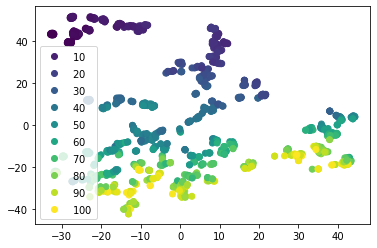

In [43]:
# Check if there are a significant amount of zeros in the data.
print(f'% of zeros in data -> {np.sum(data == 0)/data.size}')
print(f'% of nonzeros in data -> {np.sum(data != 0)/data.size}')

# Plot the data.
tsne = TSNE(random_state=42)

data_trans = tsne.fit_transform(data)

scatter_plot = plt.scatter(data_trans[:, 0], data_trans[:, 1], c=target)
plt.legend(*scatter_plot.legend_elements())
plt.show()

# NOTE: The data looks to be linearly seperable.

#### Apply model to the data.

In [44]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

gs_params = {
    'estimator': SVR(kernel='linear'),
    'param_grid': param_grid,
    'n_jobs': -1,
}

gs = GridSearchCV(**gs_params)
gs.fit(X_train, y_train)

svr = gs.best_estimator_

#### View the results of the algorithm

In [45]:
print(f'Algorithm: {svr}')

pred_train = svr.predict(X_train)
pred_test = svr.predict(X_test)

print(f'Train MSE: {mean_squared_error(pred_train, y_train)}')
print(f'Test MSE: {mean_squared_error(pred_test, y_test)}')

# NOTE: anything below 500 is an ideal MSE.

# Show predictions for 5 random schools.

indexes = set()

for i in range(5):
    indexes.add(choice(range(len(X_test))))

for index in indexes:
    print(f'\n----- {university_names[index]} -----')
    print(f'\tPrediction: {svr.predict(X_test[index].reshape(1, -1))[0]}')
    print(f'\tTarget: {y_test[index]}')

Algorithm: SVR(C=0.1, kernel='linear')
Train MSE: 216.92366531704366
Test MSE: 237.72810800110418

----- RWTH Aachen University -----
	Prediction: 54.51170215930915
	Target: 51.0

----- Emory University -----
	Prediction: 55.15960040431722
	Target: 33.0

----- University of Sussex -----
	Prediction: 8.774643131634782
	Target: 10.0

----- Thomas Jefferson University -----
	Prediction: 57.17660711213958
	Target: 50.0

----- University of Freiburg -----
	Prediction: 59.96275826891839
	Target: 59.0


#### Plot the results

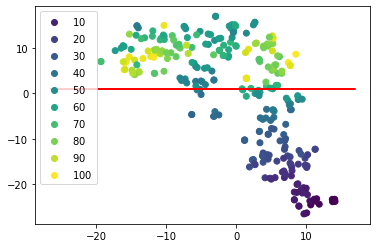

In [57]:
tsne = TSNE()

X_test_trans = tsne.fit_transform(X_test)

m = sorted(svr.coef_[0], reverse=True)[:2]    # get the most important features.
b = svr.intercept_[0]
loss = expit(X_test_trans * m + b)

scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test)
plt.plot(X_test_trans, loss, c='red')
plt.legend(*scatter.legend_elements())